# Sentiment analysis with PySpark + XGBoost
This notebook loads `Dataset-SA.csv`, preprocesses the `Summary` text with PySpark (tokenize, stopwords, TF-IDF), converts features to numpy arrays, trains an XGBoost multiclass classifier on the `Sentiment` column (positive/negative/neutral), and evaluates the model.

Notes: set JAVA_HOME for Spark — this notebook sets it to the path you provided. If you already have Spark installed separately, you can adjust accordingly.

In [1]:
# Install dependencies if missing (will use the current Python interpreter)
import sys, subprocess
packages = ['pyspark', 'xgboost', 'scikit-learn', 'pandas', 'matplotlib', 'seaborn', 'joblib', 'findspark']
for p in packages:
    try:
        __import__(p if p != 'scikit-learn' else 'sklearn')
    except Exception:
        print(f'Installing {p}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', p])
print('Dependencies ensured.')

Dependencies ensured.


In [2]:
# Set JAVA_HOME (Windows) to a Java 17 JDK and update PATH for this notebook session
import os
# Use Eclipse Adoptium JDK 17 which is typically compatible with Spark
java_path = r'C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot'
os.environ['JAVA_HOME'] = java_path
# Prepend the chosen Java bin to PATH so this Python process (and Spark) uses it
java_bin = os.path.join(java_path, 'bin')
# Put java_bin first in PATH (avoid duplicates)
path_parts = [p for p in os.environ.get('PATH','').split(os.pathsep) if p and p.lower() != java_bin.lower()]
os.environ['PATH'] = java_bin + os.pathsep + os.pathsep.join(path_parts)
print('JAVA_HOME set to', os.environ['JAVA_HOME'])
# Initialize findspark (helps locate spark when installed externally)
import findspark
try:
    findspark.init()
    print('findspark initialized')
except Exception as e:
    print('findspark init had an issue (this is OK if using pyspark pip package):', e)

JAVA_HOME set to C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot
findspark initialized


In [3]:
# Diagnostic: check Java and environment for Spark (helps debug Py4JJavaError)
import os, subprocess, sys
print('JAVA_HOME =', os.environ.get('JAVA_HOME'))
java_exec = os.path.join(os.environ.get('JAVA_HOME',''), 'bin', 'java.exe')
print('Candidate java executable:', java_exec, 'exists=', os.path.exists(java_exec))
try:
    p = subprocess.run(['java','-version'], capture_output=True, text=True)
    # java prints version info to stderr usually
    print('---- java -version output ----')
    print(p.stderr.strip() if p.stderr else p.stdout.strip())
except Exception as e:
    print('Error running java -version:', e)
print()
print('PATH entries containing java/jdk:')
for p in os.environ.get('PATH','').split(os.pathsep):
    if 'java' in p.lower() or 'jdk' in p.lower():
        print(' -', p)
print()
# Check pyspark availability (may not be installed yet)
try:
    import pyspark
    print('pyspark import OK; location:', getattr(pyspark, '__file__', None))
except Exception as e:
    print('pyspark import failed:', e)
print('Python executable:', sys.executable)
print('\nNote: Spark is most compatible with Java 8, 11, or 17 in many builds. If your JDK is newer (e.g. 19+ or 24), consider installing JDK 17 and pointing JAVA_HOME to it.')

JAVA_HOME = C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot
Candidate java executable: C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot\bin\java.exe exists= True
---- java -version output ----
openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment Temurin-17.0.16+8 (build 17.0.16+8)
OpenJDK 64-Bit Server VM Temurin-17.0.16+8 (build 17.0.16+8, mixed mode, sharing)

PATH entries containing java/jdk:
 - C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot\bin
 - C:\Program Files\Java\jdk-24.0.2\bin
 - C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot\\bin
 - C:\Program Files\Java\jdk-24.0.2\bin
 - C:\Users\udayj\AppData\Local\Programs\Eclipse Adoptium\jdk-17.0.7.7-hotspot\bin
 - C:\Program Files\Java\jdk-20\bin
 - C:\Program Files\Java\jdk-24.0.2\bin
 - C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot\\bin
 - C:\Program Files\Java\jdk-24.0.2\bin
 - C:\Users\udayj\AppData\Local\Programs\Eclipse Adoptium\jdk-17.0.7.7-hotspot\bin
 - C:\Program Files\J

In [4]:
# Start a Spark session
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName('Sentiment-XGBoost')
         .config('spark.driver.memory', '4g')
         .getOrCreate())
print('Spark version:', spark.version)

Spark version: 3.3.0


In [5]:
# Load the CSV (assumes file is in the workspace root)
# Try with proper CSV options to handle quotes and delimiters correctly
data_path = r'D:\product_review_sentiment_analysis\Dataset-SA.csv'
df = spark.read \
    .option('header', 'true') \
    .option('inferSchema', 'true') \
    .option('quote', '"') \
    .option('escape', '"') \
    .option('multiLine', 'true') \
    .csv(data_path)
print('Rows:', df.count())
df.printSchema()
df.select('Summary', 'Sentiment').show(5, truncate=200)

Rows: 205052
root
 |-- product_name: string (nullable = true)
 |-- product_price: string (nullable = true)
 |-- Rate: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Sentiment: string (nullable = true)

+----------------------------------------------------------------------------------------------+---------+
|                                                                                       Summary|Sentiment|
+----------------------------------------------------------------------------------------------+---------+
|great cooler excellent air flow and for this price its so amazing and unbelievablejust love it| positive|
|                                                         best budget 2 fit cooler nice cooling| positive|
|                                            the quality is good but the power of air is decent| positive|
|                                                             very bad product its a only a fan|

In [12]:
# Select needed columns and drop nulls
df2 = df.select('Summary', 'Sentiment').na.drop()
print('After dropna rows:', df2.count())
# Quick class balance check BEFORE filtering
print('\nAll unique sentiments found:')
df2.groupBy('Sentiment').count().orderBy('count', ascending=False).show(50)

# Filter to keep only the main sentiment categories (case-insensitive)
from pyspark.sql import functions as F
df2_filtered = df2.filter(
    F.lower(F.col('Sentiment')).isin(['positive', 'negative', 'neutral'])
)
print(f'\nRows after filtering to main sentiments: {df2_filtered.count()}')
print('\nFiltered sentiment distribution:')
df2_filtered.groupBy('Sentiment').count().show()

# Use filtered dataframe
df2 = df2_filtered

After dropna rows: 205041

All unique sentiments found:
+--------------------+------+
|           Sentiment| count|
+--------------------+------+
|            positive|166527|
|            negative| 28227|
|             neutral| 10229|
|                good|     6|
|                nice|     5|
|           excellent|     2|
|               super|     2|
|           very good|     1|
|        nice product|     1|
|        very awasome|     1|
|its same as shown...|     1|
|            nice one|     1|
|     this is amazing|     1|
|                 bad|     1|
|best for beginner...|     1|
|this is very much...|     1|
|it great my boyfr...|     1|
|this product is a...|     1|
|            worth it|     1|
|back wheel bearin...|     1|
|my daughter is ve...|     1|
|        best quality|     1|
|the bicycle was good|     1|
|all over good pro...|     1|
|                  ok|     1|
|it is very bad sk...|     1|
|cycle product is ...|     1|
|               supar|     1|
|very nice but

In [13]:
# Build PySpark ML pipeline: tokenize, remove stopwords, TF-IDF, label index
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

# Basic text cleaning: lower-case using built-in PySpark function (avoids UDF serialization issues)
df3 = df2.withColumn('text', F.lower(F.coalesce(F.col('Summary'), F.lit(''))))

regex_tokenizer = RegexTokenizer(inputCol='text', outputCol='tokens', pattern='\\W+')
stopwords_remover = StopWordsRemover(inputCol='tokens', outputCol='filtered')
hashing_tf = HashingTF(inputCol='filtered', outputCol='rawFeatures', numFeatures=1<<16)
idf = IDF(inputCol='rawFeatures', outputCol='features')
label_indexer = StringIndexer(inputCol='Sentiment', outputCol='label').fit(df3)

pipeline = Pipeline(stages=[regex_tokenizer, stopwords_remover, hashing_tf, idf, label_indexer])
pipeline_model = pipeline.fit(df3)
df_transformed = pipeline_model.transform(df3).select('features', 'label')
df_transformed.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                           |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(65536,[2860,4778,5809,13209,15563,18264,32888,55408,65262],[4.039501201651304,3.1676874222166194,7.477097015187728,3.5626631251752716,6.137117436248957,10.844392845174202,5.607950882344253,4.187345035852485,3.934390093651586])|0.0  |
|(65536,[2292,12524,15563,22346,34955,37756,63983],[6.09

In [14]:
# Train-test split
train_df, test_df = df_transformed.randomSplit([0.8, 0.2], seed=42)
print('Train rows:', train_df.count(), 'Test rows:', test_df.count())

Train rows: 164294 Test rows: 40689


In [15]:
# Cache the data for faster training (no need to convert to numpy - use PySpark ML directly)
train_df.cache()
test_df.cache()
print('Train rows:', train_df.count(), 'Test rows:', test_df.count())

Train rows: 164294 Test rows: 40689


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

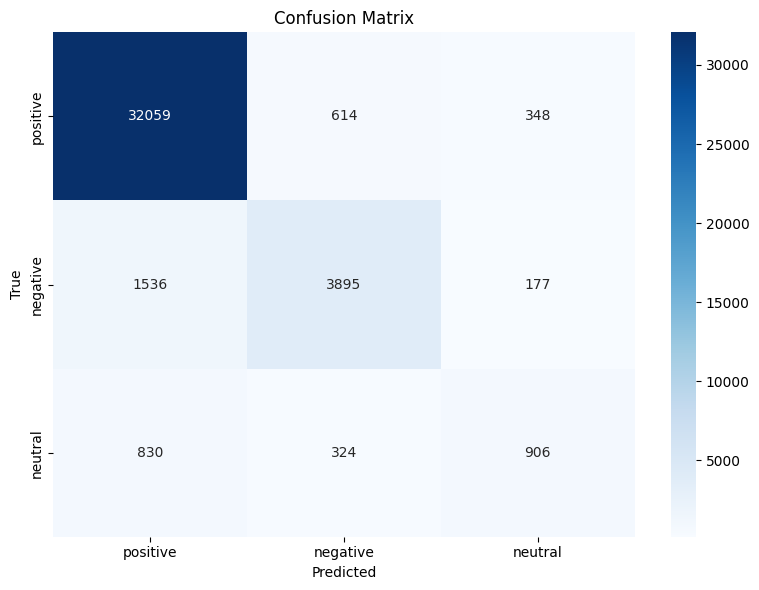

In [16]:
# Train PySpark Logistic Regression (distributed, no memory issues)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100, regParam=0.01)
lr_model = lr.fit(train_df)

# Make predictions
predictions = lr_model.transform(test_df)
predictions.select('features', 'label', 'prediction', 'probability').show(10, truncate=False)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'\nAccuracy: {accuracy:.4f}')

# Additional metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score:.4f}')

# Collect predictions for confusion matrix (only if dataset is manageable)
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

pred_and_labels = predictions.select('prediction', 'label').collect()
y_pred = np.array([row['prediction'] for row in pred_and_labels])
y_true = np.array([row['label'] for row in pred_and_labels])

# Get label names from the StringIndexer
label_names = label_indexer.labels
print(f'\nNumber of classes: {len(label_names)}')
print(f'Label names: {label_names}')

# Get unique labels that actually appear in predictions
unique_labels = np.unique(np.concatenate([y_true, y_pred]))
print(f'Unique labels in test set: {sorted(unique_labels.astype(int))}')

# Use only the labels that appear in the predictions
active_label_names = [label_names[int(i)] for i in unique_labels]

print('\nClassification Report:')
print(classification_report(y_true, y_pred, labels=unique_labels, target_names=active_label_names))

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=active_label_names, yticklabels=active_label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [23]:
# Save model as a pickle file for easy loading later
import pickle
import os

save_dir = r'D:\product_review_sentiment_analysis\saved_model'
os.makedirs(save_dir, exist_ok=True)

# Extract everything needed for inference into a simple dict
model_package = {
    'coefficients': lr_model.coefficientMatrix.toArray(),
    'intercept': lr_model.interceptVector.toArray(),
    'num_classes': lr_model.numClasses,
    'num_features': lr_model.numFeatures,
    'labels': label_indexer.labels,
    'accuracy': accuracy,
    'f1_score': f1_score
}

# Save as pickle file
model_file = os.path.join(save_dir, 'sentiment_model.pkl')
with open(model_file, 'wb') as f:
    pickle.dump(model_package, f)

file_size_mb = os.path.getsize(model_file) / (1024 * 1024)
print(f'✅ MODEL SAVED!')
print(f'\n📁 File: {model_file}')
print(f'📦 Size: {file_size_mb:.2f} MB')

# Also save labels as text for quick reference
label_file = os.path.join(save_dir, 'labels.txt')
with open(label_file, 'w') as f:
    for idx, label in enumerate(label_indexer.labels):
        f.write(f'{idx}: {label}\n')

print('\n' + '='*70)
print('MODEL PACKAGE CONTENTS:')
print('='*70)
print(f'✓ Coefficients matrix: {model_package["coefficients"].shape}')
print(f'✓ Intercepts: {model_package["intercept"].shape}')
print(f'✓ Classes: {model_package["labels"]}')
print(f'✓ Accuracy: {accuracy:.2%}')
print(f'✓ F1 Score: {f1_score:.2%}')
print('\n💾 To use later:')
print('   import pickle')
print(f'   with open(r"{model_file}", "rb") as f:')
print('       model = pickle.load(f)')
print('   labels = model["labels"]')
print('   coefficients = model["coefficients"]')

✅ MODEL SAVED!

📁 File: D:\product_review_sentiment_analysis\saved_model\sentiment_model.pkl
📦 Size: 1.50 MB

MODEL PACKAGE CONTENTS:
✓ Coefficients matrix: (3, 65536)
✓ Intercepts: (3,)
✓ Classes: ['positive', 'negative', 'neutral']
✓ Accuracy: 90.59%
✓ F1 Score: 90.06%

💾 To use later:
   import pickle
   with open(r"D:\product_review_sentiment_analysis\saved_model\sentiment_model.pkl", "rb") as f:
       model = pickle.load(f)
   labels = model["labels"]
   coefficients = model["coefficients"]
